# 06. 층화된 비례위험모형 (stratified Cox(SC) model, 층화 콕스모형)
- 콕스비례위험모형의 변형으로, **비례위험 가정(PH assumption)**을 만족하지 못하는 예측인자를 층화하여 모형에 포함
- 비례위험 가정을 만족하는 예측인자는 모형에 포함되지만, 층화된 예측인자는 모형에 포함되지 않음

In [3]:
library(survival)
library(autoReg)
library(tidyverse)

In [4]:
fit = coxph(Surv(time, status) ~ logWBC + rx + sex, anderson)
gaze(fit) %>% myft()

a flextable object.
col_keys: ` `, `coef`, `se(coef)`, `z`, `Pr(>|z|)`, `HR`, `lower`, `upper` 
header has 1 row(s) 
body has 3 row(s) 
original dataset sample: 
————————————————————————————————————————————————————————————————
           coef  se(coef)      z  Pr(>|z|)     HR  lower   upper 
————————————————————————————————————————————————————————————————
logWBC    1.682     0.337  4.997     <.001  5.376  2.779  10.398 
rx        1.504     0.462  3.258      .001  4.498  1.820  11.113 
sex       0.315     0.455  0.692      .489  1.370  0.562   3.338 
————————————————————————————————————————————————————————————————
n=42, events=30, Likelihood ratio test=47.19 on 3 df (p<.001) 

# 
# 
### 6-1 비례위험 가정 검정

- ```rx```와 ```logWBC```에 대한 비례위험 가정은 유의하지 않지만, ```sex```에 대한 비례위험 가정 검정은 p-value < 0.05로 만족X

In [5]:
cox.zph(fit)

       chisq df    p
logWBC 0.142  1 0.71
rx     0.036  1 0.85
sex    5.420  1 0.02
GLOBAL 5.879  3 0.12

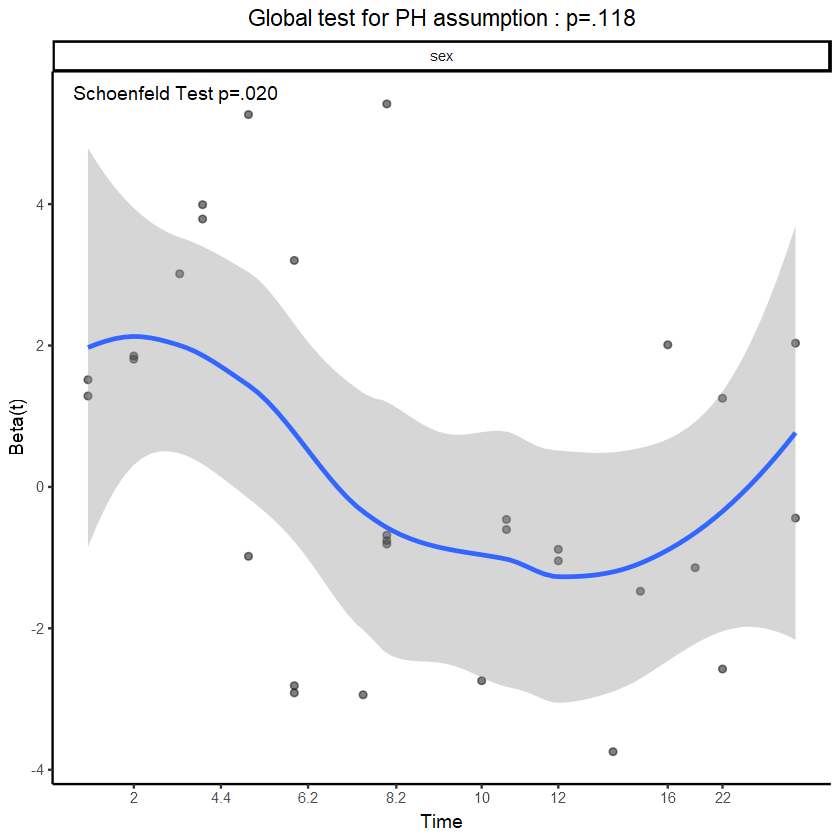

In [6]:
coxzphplot(cox.zph(fit), var = "sex")

# 
# 
### 6-2 층화된 콕스모형
- **설명변수중 1개가 비례위험 가정을 만족하지 않으므로, 층화된 콕스모형 (stratified Cox(SC) model)을 사용해 분석할 수 있음**
- **SC를 사용하게 되면, 비례위험 가정을 만족하지 않는 sex변수의 영향을 통제가능**

# 
- ```rx```의 회귀계수 : 0.9981 / 표준오차 : 0.4736
    ```rx```변수의 대조군은 1, 치료군은 0으로 입력 => 대조군의 위험비는 치료군에 비해 2.713, **치료군의 위험비는 대조군에 비해 0.37**

In [7]:
fit1 = coxph(Surv(time, status) ~ logWBC + rx + strata(sex), anderson)
summary(fit1)

Call:
coxph(formula = Surv(time, status) ~ logWBC + rx + strata(sex), 
    data = anderson)

  n= 42, number of events= 30 

         coef exp(coef) se(coef)     z Pr(>|z|)    
logWBC 1.4537    4.2787   0.3441 4.225 2.39e-05 ***
rx     0.9981    2.7131   0.4736 2.108   0.0351 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

       exp(coef) exp(-coef) lower .95 upper .95
logWBC     4.279     0.2337     2.180     8.398
rx         2.713     0.3686     1.072     6.864

Concordance= 0.812  (se = 0.059 )
Likelihood ratio test= 32.06  on 2 df,   p=1e-07
Wald test            = 22.75  on 2 df,   p=1e-05
Score (logrank) test = 30.8  on 2 df,   p=2e-07


# 
#### Wald 검정
```rx```의 회귀계수에 대한 Wald검정 결과 : p-value < 0.05
    - Wald검정 귀무가설 : $H_0 : \beta_0 = 0$

#### ```logWBC```와 ```sex```가 일정할 때, ```rx```의 회귀계수는 0이라는 가설을 기각
#### 즉, ```rx```의 효과는 통계적으로 유의하다
### $z = {{0.9981038}\over{0.4733546}} = -2.107685\;\;$ 

- ($z \sim N(0, 1)$)이기에

In [8]:
pnorm(-abs(-2.107685))*2

[1] 0.03505825

- $z^2 \sim \chi^2_{1}$

In [12]:
pchisq((-2.107685)^2, df = 1, lower.tail = F)

[1] 0.03505825

# 
#### 가능도비 검정 (likelihood ratio test)
- 가능도비 검정 : 설명변수가 없는 영모형(null model)과 비교할 때, 이 모형이 데이터를 보다 잘 설명하는지 검정
# 
- 영모형의 로그가능도 = -71.76
- 현재 모형의 로그가능도 : -55.73

In [17]:
fit1$loglik

[1] -71.76469 -55.73482

# 
#### 귀무가설하에서 LR통계량은 공변량의 개수를 자유도로 하는 카이제곱분포를 따름
- **가능도비검정 결과 : p-value < 0.05 => 현재모형이 영모형보다 더 좋은 모형**
#### $LR = (-2 \times 71.76) - (-2\times -55.73) = 32.06$

In [20]:
pchisq(32.06, df = 2, lower.tail=F)

[1] 1.092093e-07

# 
# 
### 6-3 층화된 콕스모형의 위험함수
- **위험함수는 g번째 층화된 계층을 나타내는 g가 포함**
    - g는 계층의 번호 : 현재 ```sex```는 남. 여 2개의 계층으로 이루어짐 (남자 : (g = 1) / 여자 : (g = 2))
### $h_g(t, X) = h_{0_{g}}(t)e^{-\beta_1 rx + \beta_2 logWBC}$

In [24]:
fit1$formula

Surv(time, status) ~ logWBC + rx + strata(sex)

- 남자의 위험함수
#### $h_1(t, X) = h_{0_{1}}(t)e^{-\beta_1 rx + \beta_2 logWBC}$

- 여자의 위험함수
#### $h_2(t, X) = h_{0_{2}}(t)e^{-\beta rx + \beta_2 logWBC}$ 

# 
#### 변수 ```sex```는 비례위험 가정에 포함되어 있지 않으므로, 모형에 포함되지 않음
- 대신 층화로 통제
- 변수 ```rx```와 ```logWBC```는 모형에 포함되어 있으므로, 각 변수의 효과는 다른 변수 및 층화된 변수의 효과를 통제하고 추정할 수 있음
    - 예 : 변수 ```rx```의 효과는 ```logWBC```와 ```sex```를 통제하고 $e^{\hat{\beta_1}}$로 추정 가능
    - 하지만 변수 ```sex```는 모형에 포함되어 있지 않으므로 ```sex```의 효과를 나타내는 위험비를 구할 수 없으며, **이것이 층화된 콕스모형의 단점** (```sex```는 비례위험 가정을 만족하지 않으며, 위험비가 시간에 따라 변하므로 위험비를 구하는 것이 적절하지 않음)
    
# 
#### 남녀의 위험함수를 살펴보면 기저위험함수만 다르고, 회귀계수는 같음 -> 생존곡선이 다르게 나타남

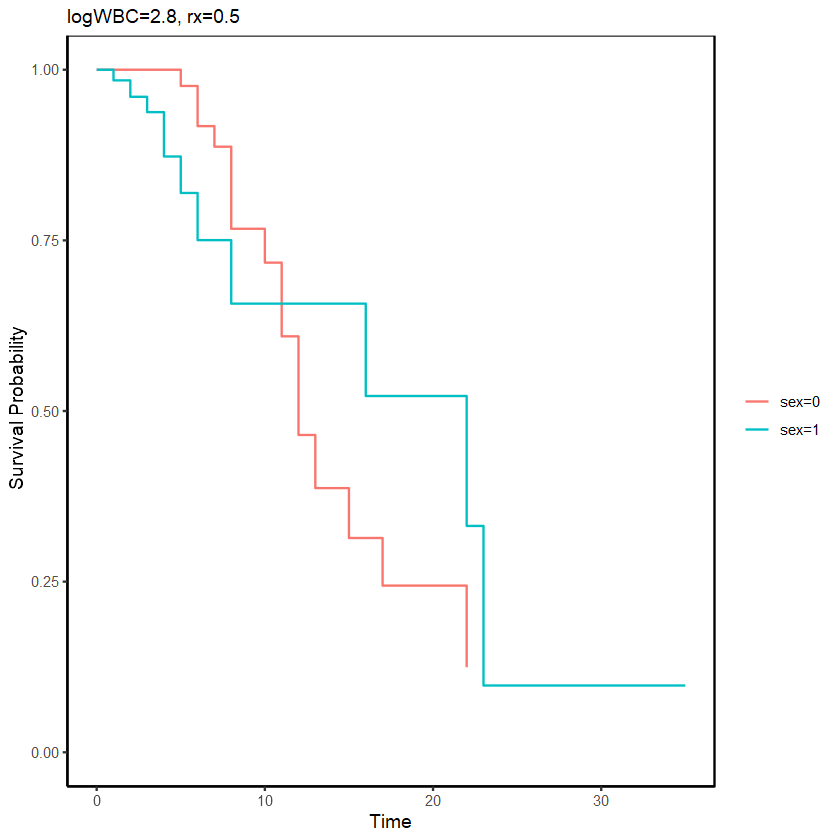

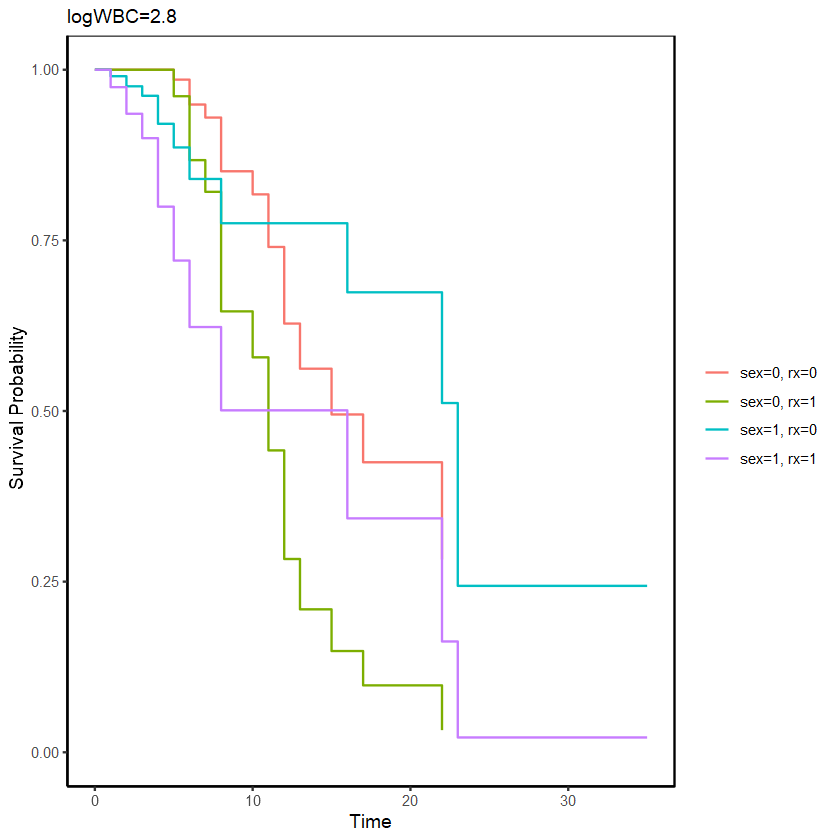

In [25]:
adjustedPlot(fit1, xnames = c("sex"))
adjustedPlot(fit1, xnames = c("sex", "rx"))

#### ```rx```와 ```logWBC```의 회귀계수는 남녀 모우 같으므로, 위험비는 동일 => 무상호작용 가정(no-interaction)

#### 회귀계수 $\beta_1$과 $\beta_2$의 추정량을 얻기 위해 부분우도함수 (partial likelihood function, L)가 데이터와 모형을 통해 만들어지고, 컴퓨터 반복을 통해 최대화
- 층화된 콕스모형의 우도함수 $L$은 $L=L_1 \times L_2$로 계산 ($L_1$과 $L_2$는 각각 남녀의 우도함수)되며, 위험함수인 $h_1(t)와 h_2(t)$에서 파생

# 
# 
### 6-4 상호작용이 있는 층화된 콕스모형

In [27]:
(fit2 = coxph(Surv(time, status) ~ rx + logWBC + rx:sex + logWBC:sex + strata(sex), anderson))

Call:
coxph(formula = Surv(time, status) ~ rx + logWBC + rx:sex + logWBC:sex + 
    strata(sex), data = anderson)

             coef exp(coef) se(coef)     z      p
rx         0.3113    1.3652   0.5636 0.552 0.5807
logWBC     1.2061    3.3406   0.5035 2.396 0.0166
rx:sex     1.6666    5.2942   0.9295 1.793 0.0730
logWBC:sex 0.5366    1.7102   0.7352 0.730 0.4655

Likelihood ratio test=35.83  on 4 df, p=3.143e-07
n= 42, number of events= 30 

# 
- 남자의 경우(sex = 0) $\beta_1 = 0.3113,\;\beta_2 = 1.2061$
- 여자의 경우(sex = 1) $\beta_1 = 0.3113 + 1.6666 = 1.9779,\;\beta_2 = 1.2061 + 0.5366 = 1.7427$

# 
#### 상호작용이 있는 모형과, 업는 모형의 로그가능도 비교

In [28]:
(LR = -2 * (fit1$loglik[2] - fit2$loglik[2]))

[1] 3.765856

- 로그가능도는 각 모형의 공변량 개수 차이(4 - 2)를 자유도로 하는 카이제곱분포를 따름
    - p-value < 0.05 => 귀무가설 기각 => 상호작용이 없는 모형이 더 좋은 모형

In [30]:
pchisq(LR, df = 2, lower.tail = F)

[1] 0.1521439